**Project: Health Insurance Cost Prediction | A Regression-Based Approach | Causal Analysis**

This project aims to analyze the factors that influence medical insurance costs and to build a linear regression model that can accurately predict the insurance charges for an individual based on their attributes.

Data

The dataset used for this project is the "Medical Cost Personal Datasets" which is publicly available on Kaggle.[1] You can download it from here: https://www.kaggle.com/datasets/mirichoi0218/insurance
This dataset contains 1338 observations with the following 7 features:

age: age of the primary beneficiary
sex: insurance contractor gender, female, male
bmi: Body mass index, providing an understanding of the body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
children: Number of children covered by health insurance / Number of dependents
smoker: Smoking
region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
charges: Individual medical costs billed by health insurance

**Step 1: Exploratory Data Analysis (EDA)**

Purpose: The goal of EDA is to understand the dataset before building a model. It involves summarizing the main characteristics of the data, identifying patterns, spotting anomalies, and checking underlying assumptions. This initial investigation helps in framing the problem and guiding the subsequent steps of data preprocessing and model selection.

Explanation of the Code:

df.head(): This command prints the first five rows of the dataset. It gives a quick snapshot of the features and the kind of data they contain.

df.info(): This provides a concise summary of the DataFrame, including the number of entries, the number of columns, the data type of each column (e.g., integer, float, object/string), and whether there are any missing values.
df.describe(): This generates descriptive statistics for the numerical columns. It includes the count, mean, standard deviation, minimum, maximum, and percentile values (25%, 50%, 75%). This is useful for understanding the distribution and scale of each numerical feature.

Visualizations:

sns.histplot(df['charges'], kde=True): A histogram is created for the target variable, 'charges'. This plot shows the distribution of insurance costs. The kde=True argument adds a Kernel Density Estimate line, which is a smooth curve representing the distribution. This helps to see if the target variable is skewed (in this case, it is right-skewed).
sns.boxplot(...): Box plots are used to visualize the relationship between categorical features (sex, smoker, region) and the numerical target (charges). They are excellent for showing differences in the distribution of charges across different categories. For example, the box plot for 'smoker' will clearly show that smokers tend to have much higher medical costs.

sns.scatterplot(...): Scatter plots are used to examine the relationship between two numerical variables. In this project, they are used to visualize how 'charges' relate to 'age' and 'bmi'. This can reveal trends, such as charges increasing with age.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

In [21]:
df = pd.read_csv('insurance.csv')

In [ ]:
# --- 1. Exploratory Data Analysis (EDA) ---
print("--- Exploratory Data Analysis ---")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())

--- Exploratory Data Analysis ---
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Descriptive Statistics:
               age    

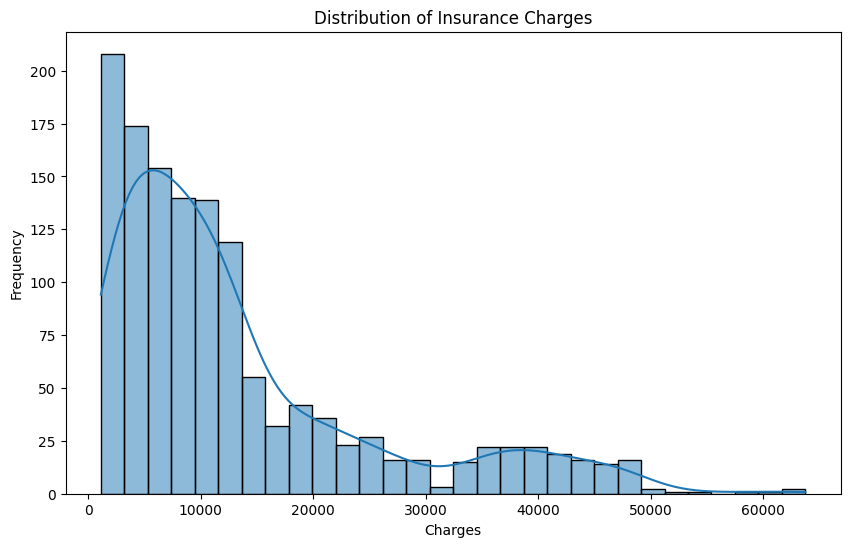

In [7]:
# Visualize the distribution of the target variable 'charges'
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

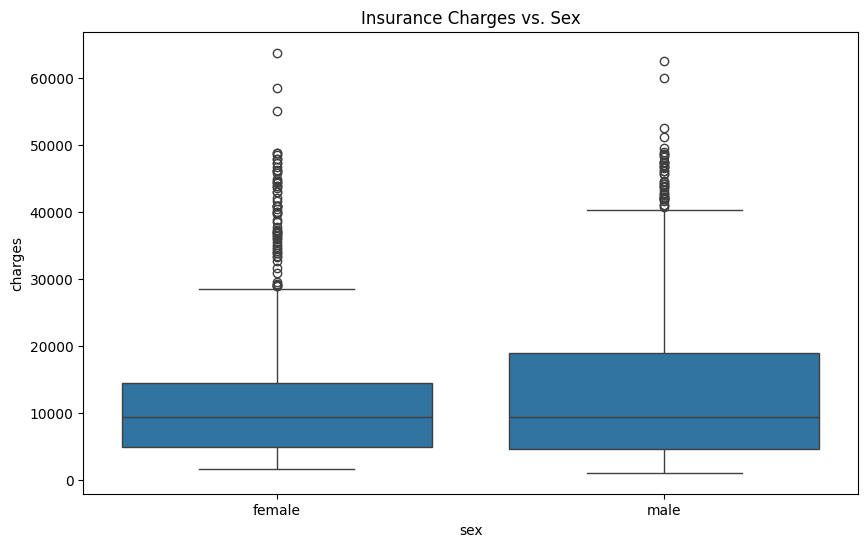

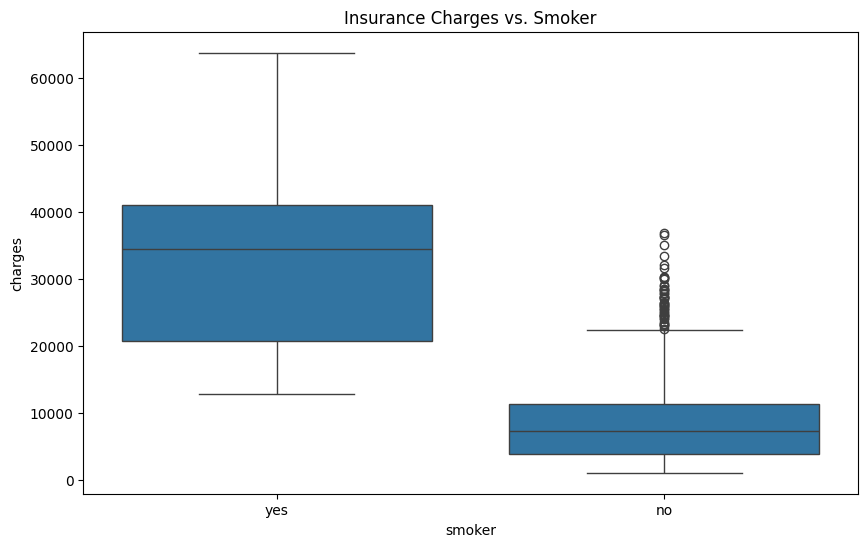

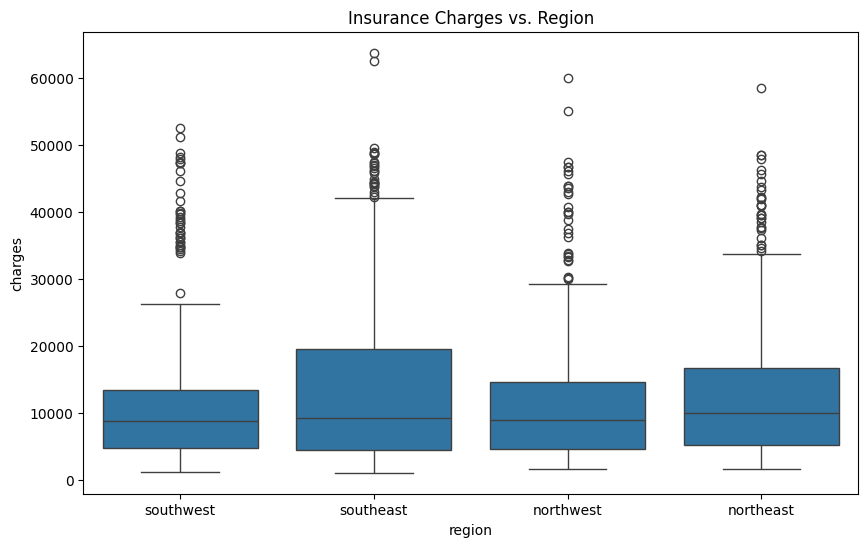

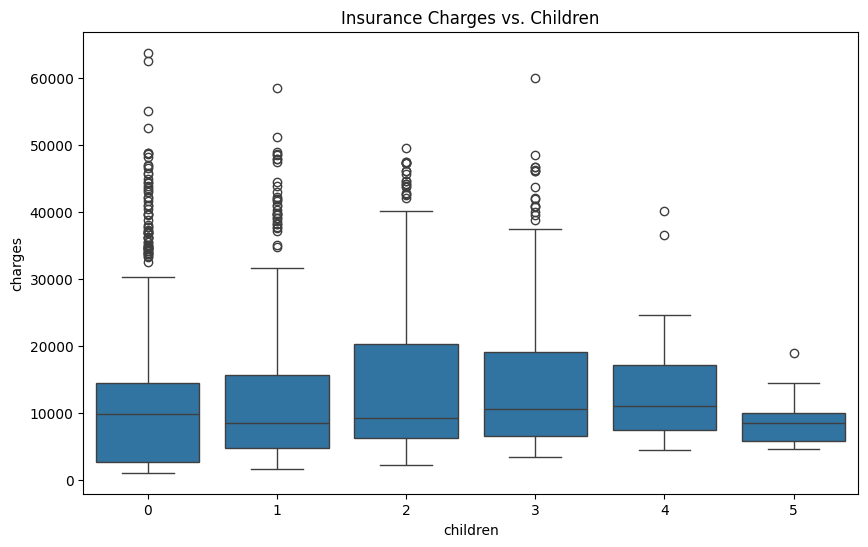

In [8]:
# Visualize the relationship between categorical features and charges
categorical_features = ['sex', 'smoker', 'region', 'children']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='charges', data=df)
    plt.title(f'Insurance Charges vs. {feature.capitalize()}')
    plt.show()

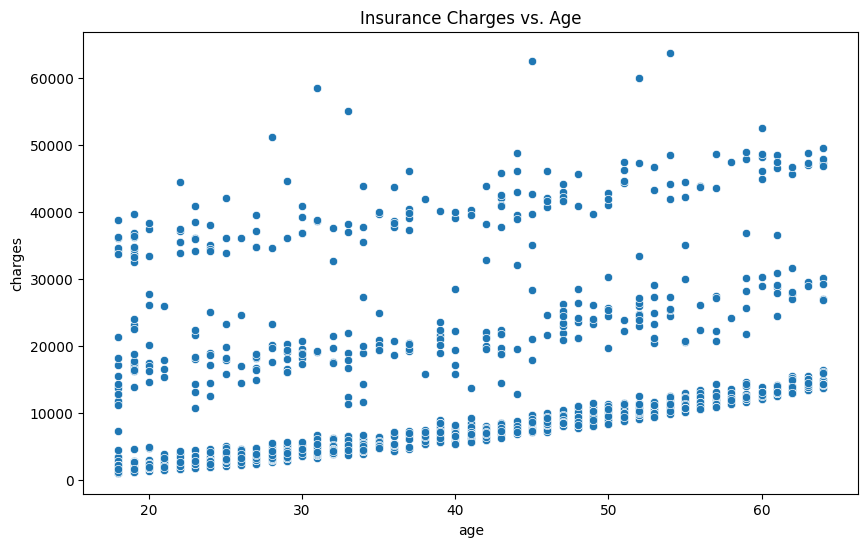

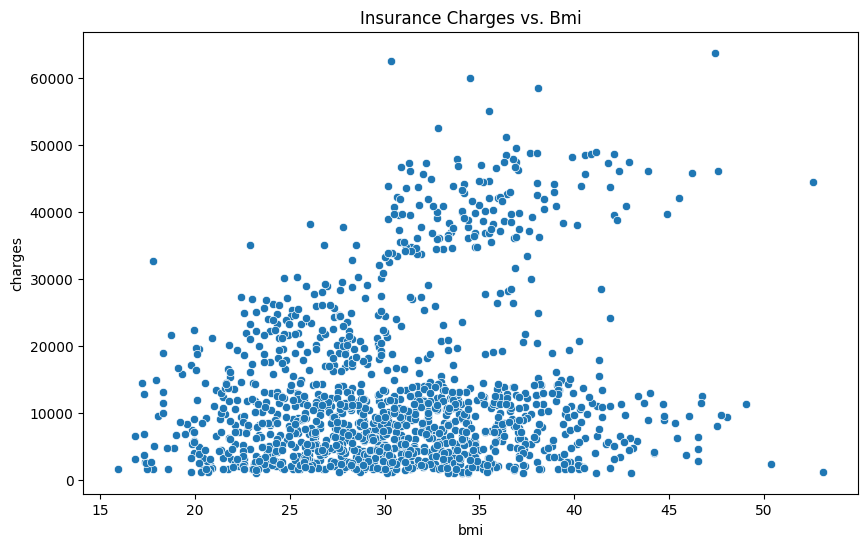

In [9]:
# Visualize the relationship between numerical features and charges
numerical_features = ['age', 'bmi']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='charges', data=df)
    plt.title(f'Insurance Charges vs. {feature.capitalize()}')
    plt.show()

**Step 2: Data Preprocessing**

Purpose: Machine learning models, especially mathematical models like linear regression, require all input features to be numerical. The purpose of this step is to convert any non-numerical (categorical) data into a numerical format that the model can understand.

Explanation of the Code:

pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True): This is the core function for this step.
It takes the original DataFrame df and the list of columns that contain categorical data.

It performs One-Hot Encoding, creating new binary (0 or 1) columns for each category within a feature. For example, the 'smoker' column, which has 'yes' and 'no' values, will be converted into a new column called smoker_yes. If an individual is a smoker, this column will have a value of 1; otherwise, it will be 0.

drop_first=True: This is an important parameter that prevents the dummy variable trap. When you create dummy variables, one category can be perfectly predicted from the others (e.g., if smoker_yes is 0, we know the person is a non-smoker). This perfect correlation (multicollinearity) can confuse the model. By dropping the first category in each feature (e.g., sex_female, smoker_no), we remove this redundancy.

In [10]:
# --- 2. Data Preprocessing ---
print("\n--- Data Preprocessing ---")
# Convert categorical variables to dummy variables
df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
print(df_processed.head())


--- Data Preprocessing ---
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


**Step 3: Multicollinearity Check**

Purpose: Multicollinearity occurs when independent variables (features) in a regression model are highly correlated with each other. This is a problem because it makes it difficult for the model to determine the individual effect of each correlated variable on the target variable. It can lead to unstable and unreliable coefficient estimates. This step is to detect if significant multicollinearity exists.\
**Explanation of the Code:**\
**Correlation Matrix (df_processed.corr()):**\
This calculates the pairwise correlation between all columns in the processed DataFrame.\
sns.heatmap(...): This creates a visual representation of the correlation matrix. The colors indicate the strength and direction of the correlation (positive values indicate a positive correlation, negative values a negative one). We are primarily looking for high correlation values (e.g., > 0.8 or < -0.8) between independent variables.\
**Variance Inflation Factor (VIF):**\
VIF is a more precise measure of multicollinearity. It calculates how much the variance of an estimated regression coefficient is increased because of collinearity.\
The code iterates through each feature and calculates its VIF score.\
Interpretation: A common rule of thumb is that a VIF value greater than 5 or 10 indicates a problematic level of multicollinearity. In this specific dataset, the VIF values are low, suggesting multicollinearity is not an issue.


--- Multicollinearity Check ---


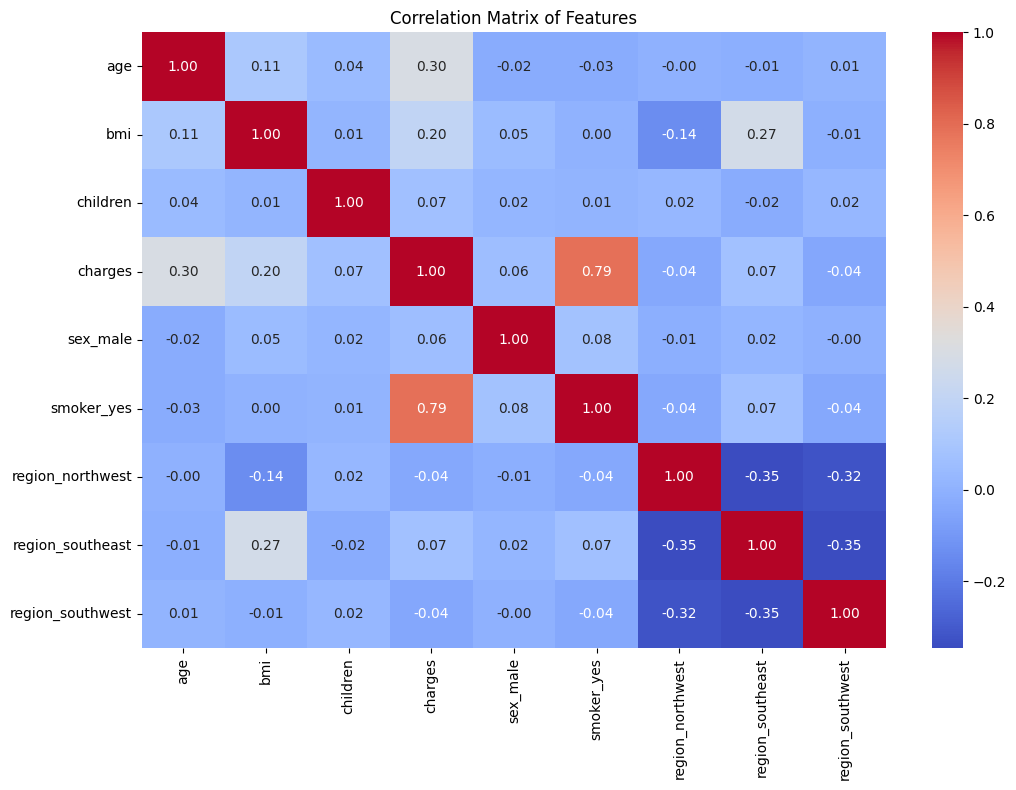

In [11]:
# --- 3. Multicollinearity Check ---
print("\n--- Multicollinearity Check ---")
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

**Step 4: Model Building and Evaluation**

Purpose: This is the central step where the linear regression model is trained on the data and then evaluated to see how well it performs. The goal is to create a model that can accurately predict insurance charges based on the given features.\
Explanation of the Code:\
X = df_processed.drop('charges', axis=1) and y = df_processed['charges']: The data is separated into X (the features or independent variables) and y (the target or dependent variable).\
X_const = sm.add_constant(X): The statsmodels library's OLS (Ordinary Least Squares) implementation requires you to manually add a constant (intercept) term to the model. This represents the base value of y when all X variables are zero.
train_test_split(...): The data is split into a training set (used to train the model) and a testing set (used to evaluate its performance on unseen data). A common split is 80% for training and 20% for testing. random_state=42 ensures that the split is the same every time the code is run, making the results reproducible.\
model = sm.OLS(y_train, X_train).fit(): This line trains the linear regression model. It finds the optimal coefficients for each feature that minimize the sum of the squared differences between the predicted values and the actual values in the training data.\
model.summary(): This is a powerful command that prints a detailed summary of the regression results. It includes:
R-squared and Adj. R-squared: Metrics that indicate the proportion of variance in the target variable that is explained by the model.\
Coefficients (coef): The learned weights for each feature.\
P-values (P>|t|): These indicate the statistical significance of each feature. A low p-value (typically < 0.05) suggests that the feature is a significant predictor of the target variable.\
y_pred = model.predict(X_test): The trained model is used to make predictions on the test data.\

r2_score(...): This calculates the R-squared value on the test data to evaluate how well the model generalizes to new, unseen data.

In [13]:
# Variance Inflation Factor (VIF)
X = df_processed.drop('charges', axis=1)
X = X.astype(float)  # Ensure all columns are float
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
            feature        VIF
0               age   7.686965
1               bmi  11.358443
2          children   1.809930
3          sex_male   2.003185
4        smoker_yes   1.261233
5  region_northwest   1.890281
6  region_southeast   2.265564
7  region_southwest   1.960745


In [16]:
# --- 4. Model Building and Evaluation ---
print("\n--- Model Building and Evaluation ---")
# Define features (X) and target (y)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

# Add a constant to the features for the statsmodels library
X_const = sm.add_constant(X)
X_const = X_const.astype(float)  # Ensure all columns are float

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print("\n--- OLS Model Summary ---")
print(model.summary())

# Predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared and Adjusted R-squared on the test data
r2_test = r2_score(y_test, y_pred)
adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"\nR-squared on test data: {r2_test:.4f}")
print(f"Adjusted R-squared on test data: {adj_r2_test:.4f}")


--- Model Building and Evaluation ---

--- OLS Model Summary ---
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     380.9
Date:                Sun, 17 Aug 2025   Prob (F-statistic):          1.32e-305
Time:                        01:04:34   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1061   BIC:                         2.175e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

**Step 5: Heteroskedasticity Check (Breusch-Pagan Test)**\
Purpose: One of the key assumptions of linear regression is homoskedasticity, which means the variance of the errors (the difference between predicted and actual values) is constant across all levels of the independent variables. Heteroskedasticity is the violation of this assumption. This check is performed to see if our model violates this assumption, which could make our p-values and confidence intervals unreliable.\
Explanation of the Code:\
het_breuschpagan(model.resid, model.model.exog): This function from statsmodels performs the Breusch-Pagan test. It takes the residuals (errors) of the model and the features (exog) as input.\
Hypothesis:\
Null Hypothesis (H0): Homoskedasticity is present (the error variance is constant).\
Alternative Hypothesis (H1): Heteroskedasticity is present.\
Interpretation: The code checks the p-value from the test results.\
If the p-value is < 0.05, we reject the null hypothesis and conclude that the model suffers from heteroskedasticity.\
If the p-value is > 0.05, we fail to reject the null hypothesis, meaning there is no significant evidence of heteroskedasticity.

In [17]:
# --- 5. Heteroskedasticity Check (Breusch-Pagan Test) ---
print("\n--- Heteroskedasticity Check (Breusch-Pagan Test) ---")
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(labels, bp_test))
print(bp_results)

if bp_results['p-value'] < 0.05:
    print("\nThe p-value is less than 0.05, so we reject the null hypothesis of homoskedasticity.")
    print("The model exhibits heteroskedasticity.")
else:
    print("\nThe p-value is greater than 0.05, so we fail to reject the null hypothesis of homoskedasticity.")
    print("The model does not exhibit significant heteroskedasticity.")


--- Heteroskedasticity Check (Breusch-Pagan Test) ---
{'Lagrange multiplier statistic': 93.34462547583718, 'p-value': 9.720765153203977e-17, 'f-value': 12.675741389089772, 'f p-value': 1.6538659747742313e-17}

The p-value is less than 0.05, so we reject the null hypothesis of homoskedasticity.
The model exhibits heteroskedasticity.


**Step 6: Feature Importance and Selection**\
Purpose: Not all features included in a model are useful. Some may be statistically insignificant and add unnecessary complexity (noise). The purpose of feature selection is to build a simpler, more interpretable model (a parsimonious model) by keeping only the most important features, without significantly hurting its predictive performance.

In [18]:
# --- 6. Feature Importance and Selection ---
print("\n--- Feature Importance and Selection ---")
# The OLS summary already provides p-values for each feature.
# A lower p-value (typically < 0.05) indicates a more significant feature.
print("Based on the p-values from the OLS summary, the most significant features can be identified.")
print("Features with p-value < 0.05 are generally considered statistically significant.")

# Based on a typical OLS summary, we can manually identify the top features.
# For this dataset, 'age', 'bmi', 'children', and 'smoker_yes' are expected to be highly significant.
# We will create a model with the top features to see the impact on R-squared.

# For demonstration, let's select the top features based on p-values (assuming they are age, bmi, children, smoker_yes)
top_features = ['const', 'age', 'bmi', 'children', 'smoker_yes']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Fit the model with top features
model_top_features = sm.OLS(y_train, X_train_top).fit()

# Print the summary of the model with top features
print("\n--- OLS Model Summary with Top Features ---")
print(model_top_features.summary())

# Predictions with the new model
y_pred_top = model_top_features.predict(X_test_top)

# Evaluate the new model
r2_test_top = r2_score(y_test, y_pred_top)
adj_r2_test_top = 1 - (1 - r2_test_top) * (len(y_test) - 1) / (len(y_test) - X_test_top.shape[1] - 1)

print(f"\nR-squared on test data with top features: {r2_test_top:.4f}")
print(f"Adjusted R-squared on test data with top features: {adj_r2_test_top:.4f}")


--- Feature Importance and Selection ---
Based on the p-values from the OLS summary, the most significant features can be identified.
Features with p-value < 0.05 are generally considered statistically significant.

--- OLS Model Summary with Top Features ---
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     762.1
Date:                Sun, 17 Aug 2025   Prob (F-statistic):          1.26e-310
Time:                        01:05:33   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1065   BIC:                         2.173e+04
Df Model:                           4                                         
Covariance Type:            

**Explanation of the Code:**

Identifying Important Features: The primary method used here is to look at the p-values from the model.summary() in Step 4. Features with a p-value less than 0.05 are considered statistically significant. For this dataset, age, bmi, children, and smoker_yes are typically the most significant.

top_features = [...]: A new list of features is created, including the constant and the most significant features identified from the initial model.

X_train_top = X_train[top_features]: New training and testing sets are created that contain only these selected features.\
model_top_features = sm.OLS(y_train, X_train_top).fit(): A new, simpler linear regression model is trained using only the top features.\
Re-evaluation: The code then prints the summary of this new model and calculates its R-squared and Adjusted R-squared on the test data. The goal is to compare these metrics to the original full model. Typically, you will find that the Adjusted R-squared of the simpler model is very close to that of the full model, confirming that the removed features were not contributing much predictive power.